In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

Load and explore the dataset

In [119]:
def load_chlorine_data():
    df = pd.read_excel('Initial_Trial_results.xlsx', sheet_name='Sheet1', engine='openpyxl')
    print("Dataset loaded successfully. First few rows:")
    print(df.head())
    print("\nDataset statistics:")
    print(df.describe())
    return df

chlorine_df = load_chlorine_data()

Dataset loaded successfully. First few rows:
       R      G      B  PPM      Gray
0  224.4  233.0  101.6   95  218.4970
1  223.5  230.2   74.6  109  212.6963
2  220.6  115.3   28.2  123  137.7013
3  216.4  212.6   35.9  136  194.6694
4  216.6  213.0   41.5  177  195.7704

Dataset statistics:
               R           G           B          PPM        Gray
count   50.00000   50.000000   50.000000    50.000000   50.000000
mean   164.71400  103.278000    6.382000   770.320000  110.792680
std     29.82669   57.837546   19.174363   395.090196   43.824290
min     96.00000    3.500000    0.000000    95.000000   30.758500
25%    146.25000   57.125000    0.000000   535.250000   79.401275
50%    162.05000  100.700000    0.050000   763.500000  107.794150
75%    181.00000  129.275000    0.425000   992.000000  131.856975
max    224.40000  233.000000  101.600000  1718.000000  218.497000


Data preprocessing

In [120]:
def preprocess_data(df):
    # Normalize RGB values (0-255 scale to 0-1)
    df[['R_norm', 'G_norm', 'B_norm']] = df[['R', 'G', 'B']] / 255
    
    # Normalize PPM values (0 to 1 range)
    max_ppm = df['PPM'].max()
    df['PPM_norm'] = df['PPM'] / max_ppm
    
    # Remove outliers using IQR method
    Q1 = df[['R', 'G', 'B', 'PPM']].quantile(0.25)
    Q3 = df[['R', 'G', 'B', 'PPM']].quantile(0.75)
    IQR = Q3 - Q1
    
    # Correct outlier filtering:
    mask = ~(((df[['R', 'G', 'B', 'PPM']] < (Q1 - 1.5 * IQR)) | (df[['R', 'G', 'B', 'PPM']] > (Q3 + 1.5 * IQR))).any(axis=1))
    filtered_df = df[mask]
    
    print(f"\nOriginal data points: {len(df)}")
    print(f"Data points after outlier removal: {len(filtered_df)}")
    return filtered_df, max_ppm

processed_df, max_ppm = preprocess_data(chlorine_df)


Original data points: 50
Data points after outlier removal: 40


Visualize the data

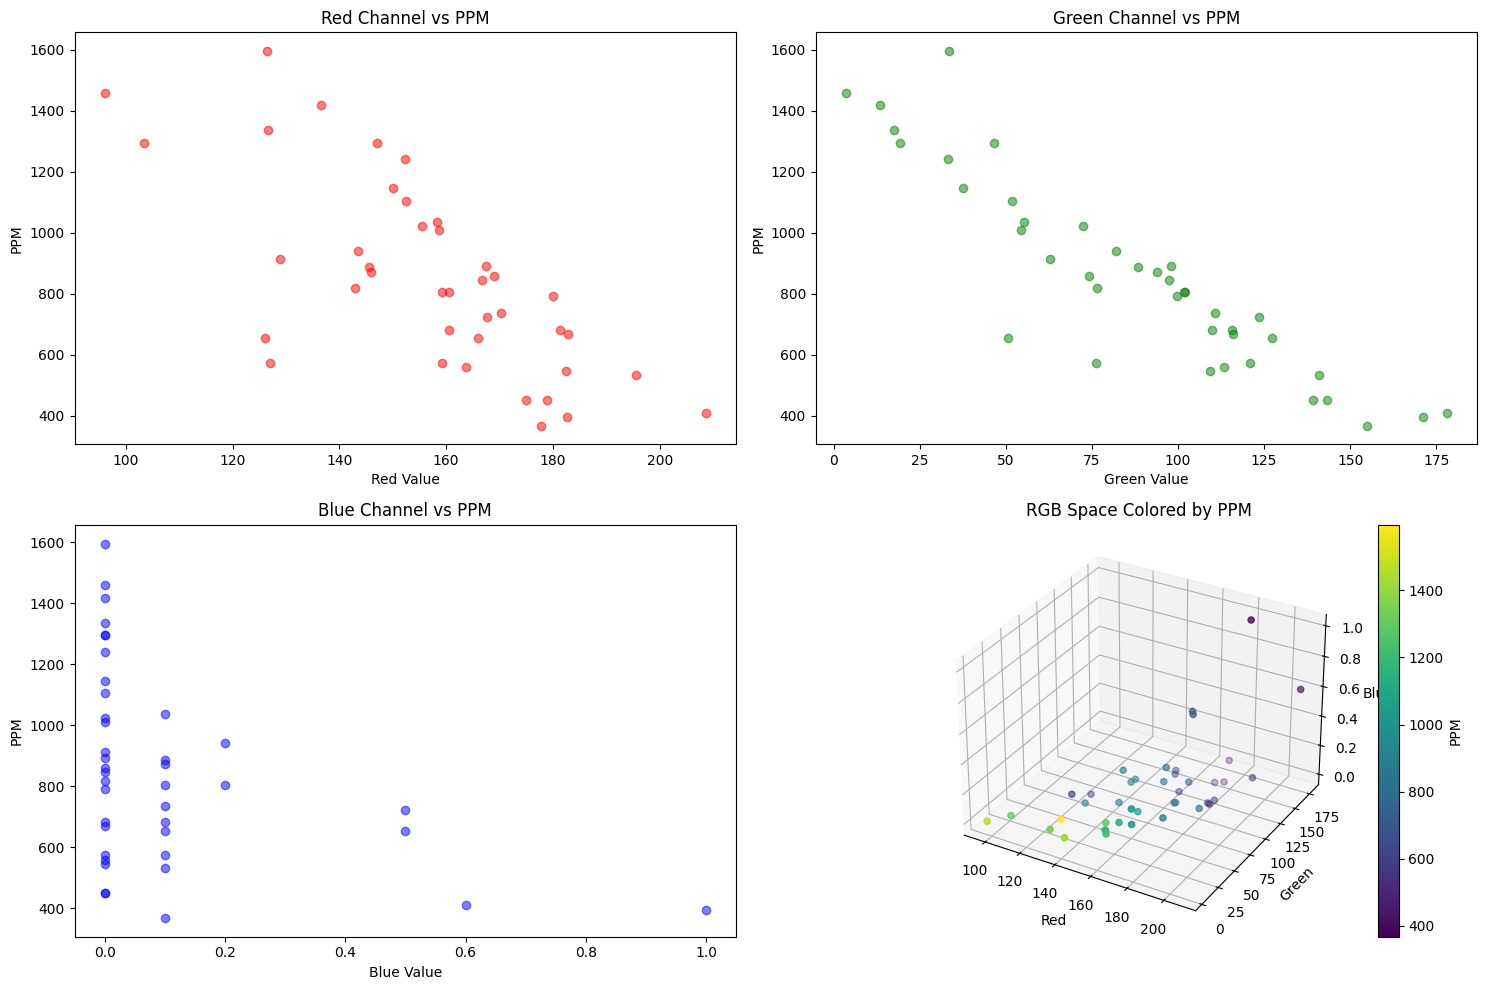

In [121]:
def visualize_data(df):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.scatter(df['R'], df['PPM'], color='red', alpha=0.5)
    plt.title('Red Channel vs PPM')
    plt.xlabel('Red Value')
    plt.ylabel('PPM')
    
    plt.subplot(2, 2, 2)
    plt.scatter(df['G'], df['PPM'], color='green', alpha=0.5)
    plt.title('Green Channel vs PPM')
    plt.xlabel('Green Value')
    plt.ylabel('PPM')
    
    plt.subplot(2, 2, 3)
    plt.scatter(df['B'], df['PPM'], color='blue', alpha=0.5)
    plt.title('Blue Channel vs PPM')
    plt.xlabel('Blue Value')
    plt.ylabel('PPM')
    
    ax = plt.subplot(2, 2, 4, projection='3d')
    sc = ax.scatter(df['R'], df['G'], df['B'], c=df['PPM'], cmap='viridis')
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('RGB Space Colored by PPM')
    plt.colorbar(sc, ax=ax, label='PPM')
    
    plt.tight_layout()
    plt.show()
    
visualize_data(processed_df)


Train and evaluate models

Shape after NaN removal: X=(40, 3), y=(40,)

Training Linear Regression model...
Training Polynomial Regression model (degree=2)...

Linear Regression Performance:
Normalized MSE: 0.000614
PPM MSE: 1811.04
R² Score: 0.9740


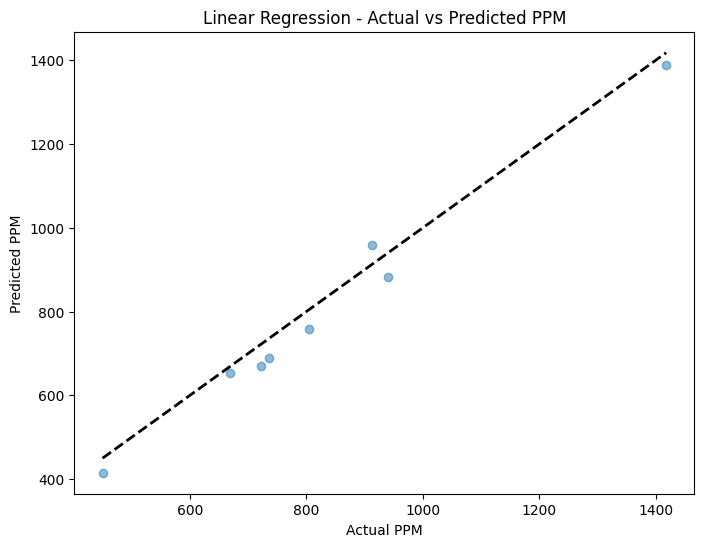


Polynomial Regression (degree=2) Performance:
Normalized MSE: 0.001885
PPM MSE: 5562.54
R² Score: 0.9201


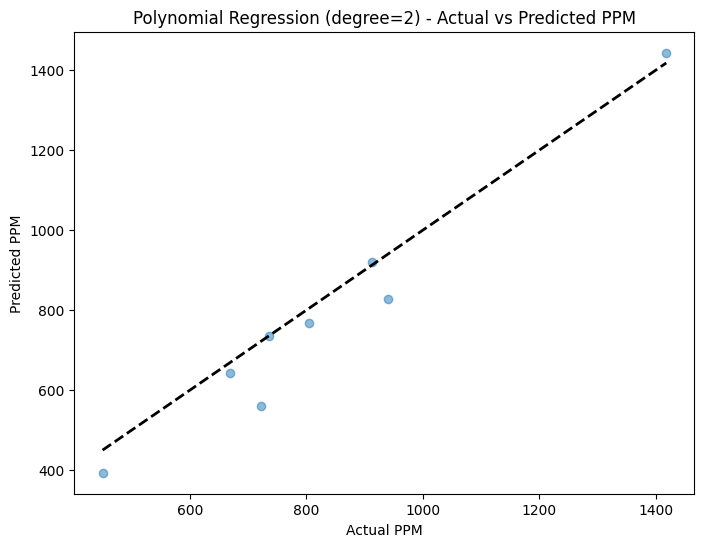

In [128]:
def train_and_evaluate(X, y, max_ppm):

    # Impute missing values in X
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    # Remove samples where y is NaN
    valid_indices = ~np.isnan(y)
    if valid_indices.sum() == 0:
        print("Warning: No valid samples found after NaN removal. Using all samples as is.")
        X_clean = X_imputed
        y_clean = y
    else:
        X_clean = X_imputed[valid_indices]
        y_clean = y[valid_indices]
    
    print(f"Shape after NaN removal: X={X_clean.shape}, y={y_clean.shape}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
    
    # Linear Regression
    print("\nTraining Linear Regression model...")
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    # Polynomial Regression (degree=2)
    print("Training Polynomial Regression model (degree=2)...")
    poly_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    poly_reg.fit(X_train, y_train)
    
    # Evaluate models
    def evaluate_model(model, model_name):
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        y_test_ppm = y_test * max_ppm
        y_pred_ppm = y_pred * max_ppm
        ppm_mse = mean_squared_error(y_test_ppm, y_pred_ppm)
        
        print(f"\n{model_name} Performance:")
        print(f"Normalized MSE: {mse:.6f}")
        print(f"PPM MSE: {ppm_mse:.2f}")
        print(f"R² Score: {r2:.4f}")
        
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test_ppm, y_pred_ppm, alpha=0.5)
        plt.plot([y_test_ppm.min(), y_test_ppm.max()], [y_test_ppm.min(), y_test_ppm.max()], 'k--', lw=2)
        plt.xlabel('Actual PPM')
        plt.ylabel('Predicted PPM')
        plt.title(f'{model_name} - Actual vs Predicted PPM')
        plt.show()
    
    evaluate_model(lin_reg, "Linear Regression")
    evaluate_model(poly_reg, "Polynomial Regression (degree=2)")
    
    return lin_reg, poly_reg
    
feature_columns = ['R_norm', 'G_norm', 'B_norm']
X = processed_df[feature_columns]  # Keep as DataFrame for imputer
y = processed_df['PPM_norm'].values
    
lin_model, poly_model = train_and_evaluate(X, y, max_ppm)

Example prediction


In [127]:
example_rgb = np.array([[200, 150, 50]]) / 255  # Normalize example RGB values
ppm_scale = 1.0
print("\nExample Prediction:")
print(f"Input RGB (normalized): {example_rgb}")
    
lin_pred = lin_model.predict(example_rgb) * ppm_scale
poly_pred = poly_model.predict(example_rgb) * ppm_scale
    
print(f"Linear Regression Prediction: {lin_pred[0]:.2f} PPM")
print(f"Polynomial Regression Prediction: {poly_pred[0]:.2f} PPM")


Example Prediction:
Input RGB (normalized): [[0.78431373 0.58823529 0.19607843]]
Linear Regression Prediction: 7.12 PPM
Polynomial Regression Prediction: -3400.02 PPM
